In [1]:
%pwd

'/Users/verasale/iCloud Drive (Archive)/Desktop/RU2018-2020/2019-20/Major_research_project/Data_analysis/Physiological/EDA processed/EDA_urban'

In [10]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np

#import pyphysio
import pyphysio as ph
import pandas as pd
import pyphysio.filters.Filters as flt

# (should) show plots in a separate window
%matplotlib inline

In [11]:
# open file
df_EDA = pd.read_csv('EDA_pp1.csv', header=None)

In [12]:
n_of_rows = df_EDA.count()
print(n_of_rows)

0    25140
dtype: int64


In [13]:
#computing n of rows to keep 
n_rows = 3720*4 
print(n_rows )

14880


In [14]:
#using pandas to drop all the rows / seconds after 3720s 
df_EDA = df_EDA.drop(df_EDA.index[14880:25140])
print(df_EDA)

               0
0       0.000000
1       0.838918
2       1.182437
3       1.620537
4       2.098371
...          ...
14875  14.684529
14876  14.696056
14877  14.639702
14878  14.502657
14879  14.336154

[14880 rows x 1 columns]


In [15]:
# create the signal
fsamp = 4 #Hz
tstart_df_EDA = 0 #s


eda = ph.EvenlySignal(values = df_EDA.values.ravel(), 
                      sampling_freq = fsamp,
                      start_time = tstart_df_EDA)

In [17]:
#count n of rows to get time of recording (s) 
n_of_rows = df_EDA.count()
print(n_of_rows)
#walk time in seconds 
walk_time_seconds = n_of_rows/4
print(walk_time_seconds)
#walk time in minutes
walk_time_minutes = walk_time_seconds/60
print(walk_time_minutes)

# save data 
outputFile=open("time_pp1.txt", 'a')
outputFile.write("{}\n{}\n".format(walk_time_seconds, walk_time_minutes))
outputFile.close()


0    14880
dtype: int64
0    3720.0
dtype: float64
0    62.0
dtype: float64


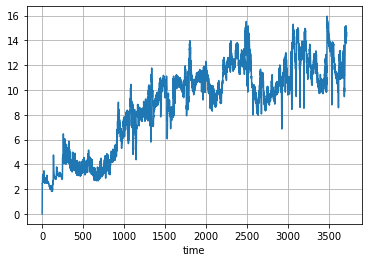

In [18]:
# plot
plot = eda.plot()
# plt.show() #using matplotlib to show the plot

In [19]:
#signal is quite noisy (moving artifacts)
#consider the possibility of filtering it

#e.g. simple moving average filter
mov_avg = flt.ConvolutionalFilter('rect', win_len = 1)
eda = mov_avg(eda)

#however, check that you are not losing information


In [20]:
## cutting recording based on GPS: 102mins total / 3720s 


#create baseline (10mins) / label variable
#[0s-600s] #baseline 
#[600s -3720s] #actual recording session 


label = np.zeros(3720) #s
label[0:600] = 1
label[600:3720] = 2

label = ph.EvenlySignal(label, sampling_freq = 1, signal_type = 'label')

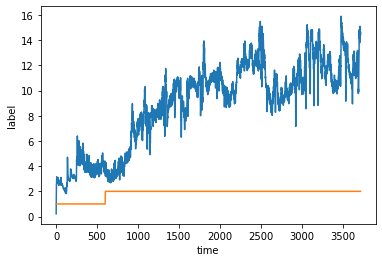

In [21]:
#see also the plots
eda.plot()
label.plot()

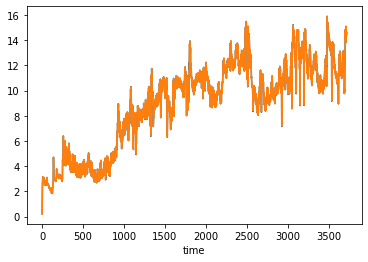

In [22]:
## filtering 
eda_filt = ph.IIRFilter(fp=0.8, fs=1.1, ftype='ellip')(eda)

eda.plot()
eda_filt.plot()

In [23]:
eda = eda_filt

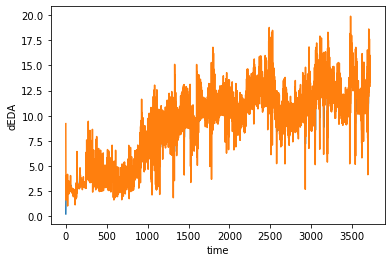

In [24]:
# get duration eda
# eda.get_duration() 

## estimate the driver function 
driver = ph.DriverEstim(t1=.75, t2=2)(eda)
eda.plot()
driver.plot()

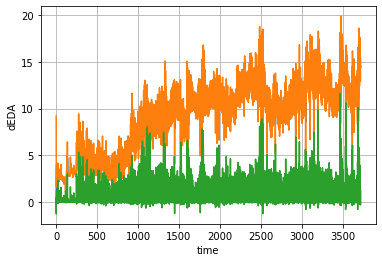

In [25]:
## compute tonic and phasic components
phasic, tonic, tmp_ = ph.PhasicEstim(delta=0.02)(driver)
eda.plot()
driver.plot()
phasic.plot()

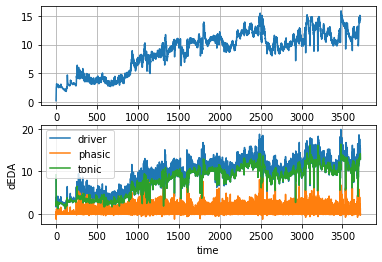

In [26]:
# check results so far
plt.figure() 
ax1 = plt.subplot(211)
eda.plot()
plt.subplot(212, sharex = ax1)
driver.plot()
phasic.plot()
tonic.plot()
plt.legend(['driver', 'phasic', 'tonic'])
plt.show()

In [27]:
## define a list of indicators
indicators_eda = [ph.Mean(name='PhaMean'),
                  ph.StDev(name='StDev'),
                  ph.AUC(name='AUC'),
                  ph.PeaksMean(name='PeaksMean', delta=0.02), 
                  ph.DurationMean(name='DurMean', delta=0.02)]


In [28]:
#fixed length windowing
fixed_length = ph.FixedSegments(step = 60, width = 60, labels = label)              
                  
## compute indicators of phasic signal
#pha_ind, col_names = ph.fmap(fixed_length, ph.preset_phasic(delta=0.02), phasic) #you should use the indicators you listed before
pha_ind, col_names = ph.fmap(fixed_length, indicators_eda, phasic) #you should use the indicators you listed before

In [29]:
#save results into a dataframe
phasic_indicators = pd.DataFrame(pha_ind, columns=col_names)

In [30]:
phasic_indicators.head()

,begin,end,label,PhaMean,StDev,AUC,PeaksMean,DurMean
0,0.0,60.0,1.0,0.237634,0.431710,14.258044,0.511537,1.416667
1,60.0,120.0,1.0,0.084141,0.159060,5.048461,0.243277,1.476190
2,120.0,180.0,1.0,0.236737,0.487816,14.204195,0.439163,1.451923
3,180.0,240.0,1.0,0.127116,0.183904,7.626938,0.279206,1.428571
4,240.0,300.0,1.0,0.707377,1.103072,42.442602,1.599127,1.425000


In [31]:
phasic_indicators.to_csv('phasicindicators_pp1.csv')


{'whiskers': [<matplotlib.lines.Line2D at 0x1c1f406650>,
 'caps': [<matplotlib.lines.Line2D at 0x1c1f3ff9d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c1f3ff990>,
 'medians': [<matplotlib.lines.Line2D at 0x1c1f40db90>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c1f406c90>,
 'means': []}

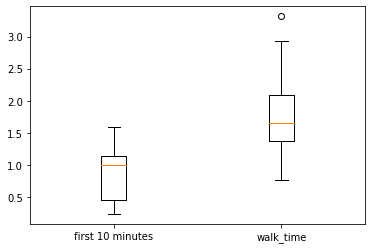

In [32]:
## Box-Whisker plot
# extract column with the labels for each window
label_w = pha_ind[:, np.where(col_names == 'label')[0]]

# extract column with PksMean values
# computed from each window
pksmean_w = pha_ind[:, np.where(col_names == 'PeaksMean')[0]]

pksmean_baseline = pksmean_w[np.where(label_w==1)[0]]
pksmean_walk_time = pksmean_w[np.where(label_w==2)[0]]

## create a boxplot and a whisker plot
## compare the distribution of the RRmean indicator
plt.boxplot([pksmean_baseline, pksmean_walk_time],
              labels=['first 10 minutes', 'walk_time'])

##plt.show()